In [110]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import scipy
import joblib
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy
import matplotlib.patches as mpatches
from concurrent.futures import ProcessPoolExecutor
from itertools import product
from astroquery.xmatch import XMatch
from scipy import stats
from matplotlib.patches import Ellipse
from astropy.table import Table

In [ ]:
catalog = pd.read_csv('data/mock_galaxy_catalog.txt', delim_whitespace=True, names=['name', 'ra', 'dec', 'z'], skiprows=1)
catalog_dict = {col: catalog[col].values for col in catalog.columns}
HL_samples = joblib.load('output/equal_samples_HL.pkl')
HLV_samples = joblib.load('output/equal_samples_HLV.pkl')

/tmp/ipykernel_2678/2528060379.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  catalog = pd.read_csv('data/mock_galaxy_catalog.txt', delim_whitespace=True, names=['name', 'ra', 'dec', 'z'], skiprows=1)


In [ ]:
def get_confidence_intervals(samples, confidence=0.90):
    ra_mean = np.mean(samples[:,0])
    dec_mean = np.mean(samples[:,1])
    cov = np.cov(samples[:,0], samples[:,1])
    eigvals, eigvecs = np.linalg.eig(cov)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    chi2_val = stats.chi2.ppf(confidence, df=2)
    width, height = 2 * np.sqrt(eigvals * chi2_val)
    return ra_mean, dec_mean, width, height, angle

def plot_ellipses(samples, confidence=0.90, labels=['HL', 'HLV']):
    for sample, label  in zip(samples, labels):
        ra_mean, dec_mean, width, height, angle = get_confidence_intervals(sample, confidence)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.scatter(sample[:, 0], sample[:, 1], s=1, alpha=0.1, label=f"{label} samples", color='red')
        ax.plot(catalog_dict['ra'], catalog_dict['dec'], 'o', markersize=4, color='blue', label='Catalog', zorder=100)
        ellipse = Ellipse((ra_mean, dec_mean), width, height, angle=angle, edgecolor='black', facecolor='none', lw=1)
        ax.add_patch(ellipse)

        ax.set_xlabel('Right Ascension (rad)')
        ax.set_ylabel('Declination (rad)')
        plt.show()

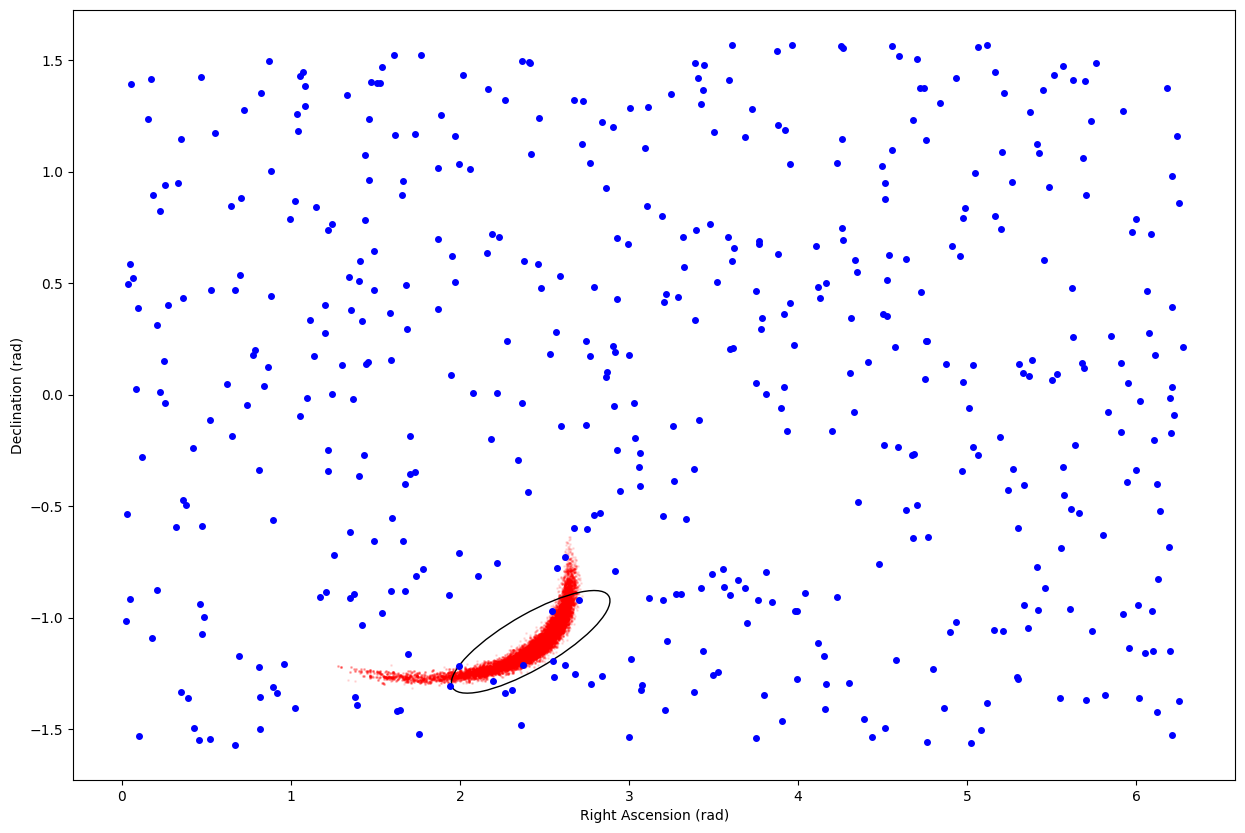

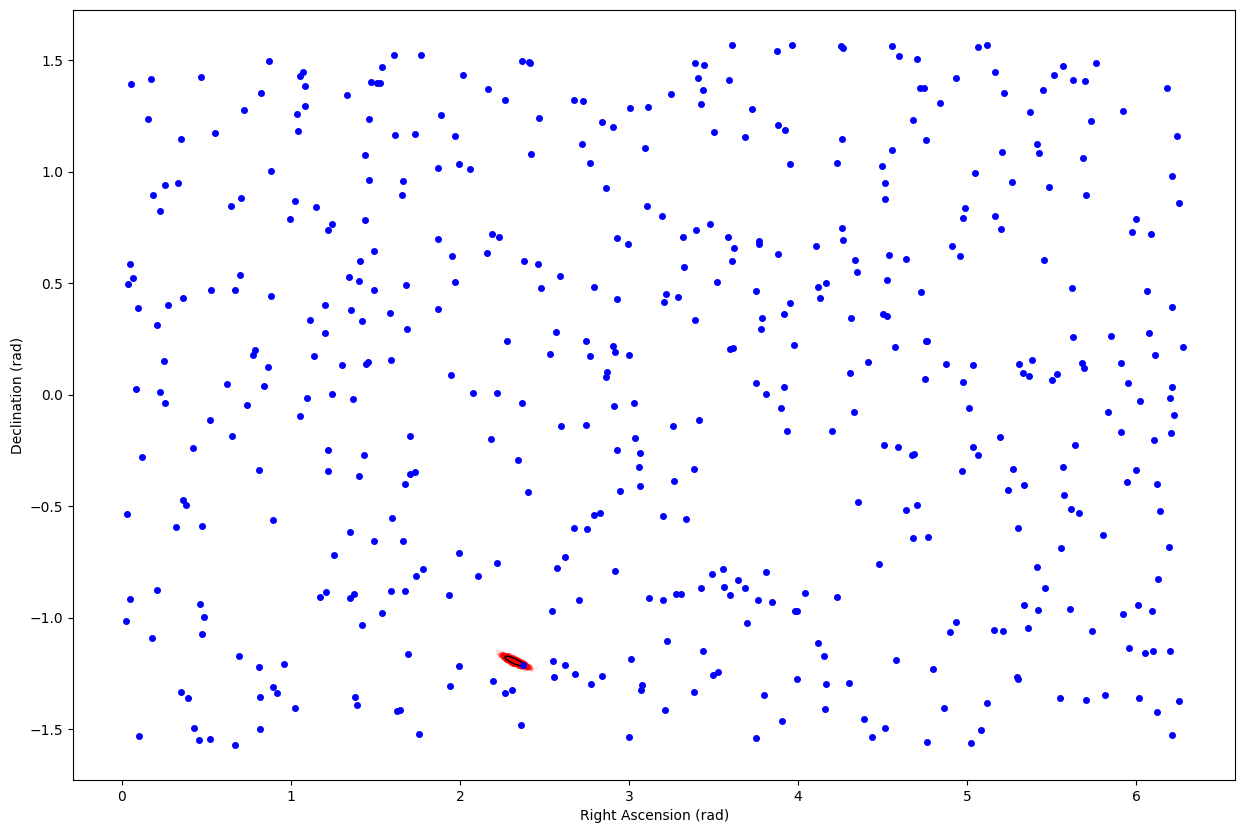

In [115]:
plot_ellipses([HL_samples, HLV_samples], confidence=0.90, labels=['HL', 'HLV'])

In [ ]:
def in_ellipse(ra, dec, ra_mean, dec_mean, angle, width, height):
    dx = ra - ra_mean
    dy = dec - dec_mean
    cos = np.cos(np.radians(-angle))
    sin = np.sin(np.radians(-angle))
    x_rotated = dx * cos - dy * sin
    y_rotated = dx * sin + dy * cos
    return (x_rotated**2 / (width / 2)**2 + y_rotated**2 / (height / 2)**2) <= 1

def cross_match(samples, catalog_dict, confidence=0.90, labels=['HL', 'HLV']):
    matches = []
    for sample, label in zip(samples, labels):
        print(f"\nCross-matching {label} samples with the catalog...")
        ra_mean, dec_mean, width, height, angle = get_confidence_intervals(sample, confidence)
        inside = np.array([in_ellipse(ra, dec, ra_mean, dec_mean, angle, width, height) for ra, dec in zip(catalog_dict['ra'], catalog_dict['dec'])])
        matched_catalog = np.column_stack((catalog_dict['name'][inside], catalog_dict['ra'][inside], catalog_dict['dec'][inside], catalog_dict['z'][inside]))  
        matched_df = pd.DataFrame(matched_catalog, columns=['name', 'ra', 'dec', 'z'])
        print(matched_df)
        matches.append(matched_df)
    return matches

In [148]:
matched_dfs = cross_match([HL_samples, HLV_samples], catalog_dict, confidence=0.90, labels=['HL', 'HLV'])


Cross-matching HL samples with the catalog...
          name     ra    dec      z
0  MGC+JYRDAGO  2.196 -1.285  1.823
1  MGC+JGS5HZS  2.543 -0.969  0.797
2  MGC+J07PCIH  2.706 -0.922  1.514
3  MGC+J2DG22T  1.993 -1.219  1.807
4  MGC+JN7U119  2.375 -1.211  0.226

Cross-matching HLV samples with the catalog...
          name     ra    dec      z
0  MGC+JN7U119  2.375 -1.211  0.226


In [180]:
def measure_hubble(samples, df):
    dl_samples = samples[:,4]*1e3 #Gpc to Mpc
    dl_mean = np.mean(dl_samples)
    dl_std = np.std(dl_samples)
    dl_interval = stats.norm.interval(0.90, loc=dl_mean, scale=dl_std/np.sqrt(len(dl_samples)))
    dl_uncertainty = (dl_interval[1] - dl_interval[0]) / 2
    z = df['z'].astype(float).values[0]
    v = z * 2.99792458e5  # Convert redshift to velocity in km/s
    hubble = v/dl_mean  # Convert to km/s/Mpc
    hubble_uncertainty = v/dl_mean**2 * dl_uncertainty
    print(f"Hubble constant: {hubble} km/s/Mpc ± {hubble_uncertainty} km/s/Mpc")

In [181]:
measure_hubble(HLV_samples, matched_dfs[1])

Hubble constant: 66.6740685374864 km/s/Mpc ± 0.017622430675461948 km/s/Mpc
